In [0]:
from IPython.display import clear_output
from IPython.display import display
from google.colab import widgets

In [0]:
! pip install torch torchvision
clear_output()

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

palettes = [
    '#D870AD', '#B377D9', '#7277D5', 
    '#4B8CDC', '#3BB1D9', '#3BBEB0', 
    '#3BB85D', '#82C250', '#B0C151', 
    '#F5BA42', '#F59B43', '#E7663F', 
    '#D94C42']
cc_ = np.array(palettes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.__version__)

cuda 1.0.0


In [0]:
def conv_down_size(size, kernel_size, stride, padding):
    return (size - kernel_size +2*padding)/stride + 1

In [7]:
size = 28
size = conv_down_size(size, 3, 1, 0)
print(size)
size = conv_down_size(size, 3, 1, 1)
print(size)
size = conv_down_size(size, 2, 2, 1)
print(size, size**2*8)
size = conv_down_size(size, 3, 1, 0)
print(size)
size = conv_down_size(size, 2, 2, 0)
print(size, size**2*8*2)
size = conv_down_size(size, 3, 1, 0)
print(size)
size = conv_down_size(size, 2, 2, 0)
print(size, size**2*8*4)
# size = conv_down_size(size, 3, 1, 0)
# print(size)
# size = conv_down_size(size, 2, 2, 1)
# print(size)

26.0
26.0
14.0 1568.0
12.0
6.0 576.0
4.0
2.0 128.0


In [0]:
train_data = torchvision.datasets.FashionMNIST("fashion", train=True,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True
                                       )
test_data = torchvision.datasets.FashionMNIST("fashion", train=False,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True
                                       )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=25,
                                           shuffle=True
                                          )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=25,
                                           shuffle=True
                                          )
clear_output()

In [0]:
cat2name = {0: "T-Shirt", 1: "Trouser", 2: "Pullover", 
           3: "Dress", 4: "Coat", 5: "Sandals", 6: "Shirt",
           7: "Sneaker", 8: "Bag", 9: "Boots"}

In [0]:
class ConvNet(nn.Module):
    """
    Convolution Net that classifies MNIST images
    """
    def __init__(self, dim_hid=8, dim_embed=50, n_class=10):
        super(ConvNet, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, dim_hid, 3,1,0),
            nn.BatchNorm2d(dim_hid),
            nn.ReLU(),
            nn.Conv2d(dim_hid, dim_hid, 3,1,1),
            nn.BatchNorm2d(dim_hid),
            nn.ReLU(),
            nn.MaxPool2d(2,2,1)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(dim_hid, 2*dim_hid, 3,1,0),
            nn.BatchNorm2d(2*dim_hid),
            nn.ReLU(),
            nn.Conv2d(2*dim_hid, 2*dim_hid, 3,1,1),
            nn.BatchNorm2d(2*dim_hid),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(2*dim_hid, 4*dim_hid, 3,1,0),
            nn.BatchNorm2d(4*dim_hid),
            nn.ReLU(),
            nn.Conv2d(4*dim_hid, 4*dim_hid, 3,1,1),
            nn.BatchNorm2d(4*dim_hid),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0)
        )
        
        self.out = nn.Sequential(
            nn.Linear(2*2*4*dim_hid, dim_embed*8),
            nn.LeakyReLU(),
            nn.Linear(dim_embed*8, dim_embed*4),
            nn.LeakyReLU(),
            nn.Linear(dim_embed*4, dim_embed),
            nn.LeakyReLU(), 
            nn.Linear(dim_embed, n_class)
        )
        
    def forward(self, img):
        
        out = self.conv0(img)
        out = self.conv1(out)
        out = self.conv2(out)
        batch_size, _, _, _ = out.size()

        out = out.view(batch_size, -1)

        out = self.out(out)
        
        return out

In [0]:
model = ConvNet().to(device)
x_entropy = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

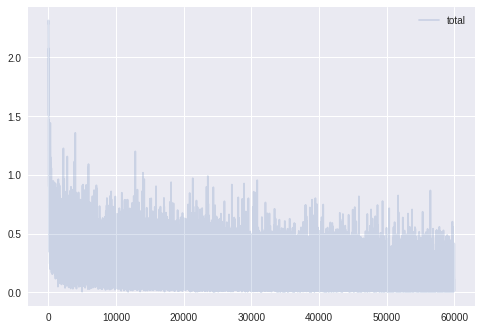

In [32]:
n_epoch = 25
loss_ = {"xentropy": [], "total": []}
# w_reg = 0.1
model.train()
# nn.utils.clip_grad_value_(model.parameters(), clip_value=10)
for edx in range(n_epoch):
    
    for bdx, (xdata, ydata) in enumerate(train_loader):
        
        xdata = xdata.to(device)
        ydata = ydata.to(device)
        
        
        logit = model(xdata)
        
        
        xentropy = x_entropy(logit, ydata)
        
        loss = xentropy
        
        loss_["xentropy"].append(xentropy.item())
        loss_["total"].append(loss.item())     
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        if (bdx+1) % 5 == 0:
            #clear_output(wait=True)
            print(
                "#{:3d}: {:.1f}% loss={:.2f}, dloss={:.2f}%".format(
                    edx+1, 100*(bdx+1)/len(train_loader), loss_["total"][-1], 
                    (loss_["total"][-1]-loss_["total"][-5])/loss_["total"][-5]*100)
                )
    display(plt.gcf())
    clear_output(wait=True)
    plt.plot(np.array(loss_["total"]), label="total", alpha=0.2)
    #plt.semilogy(np.array(loss_["xentropy"]), label="cross entropy", alpha=0.2)
    
    plt.legend(loc=0)
    plt.show()

In [0]:
def get_acc(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    for (x, y) in loader:
        x = x.to(device)
        y = y.to(device)
        logit = model(x)
        _, predict = logit.max(dim=1)
        predict = predict.detach()
        correct += (predict==y).sum().item()
        total += y.size()[0]
        
    return correct, total, correct/total

In [34]:
get_acc(model, train_loader)

(58220, 60000, 0.9703333333333334)

In [35]:
get_acc(model, test_loader)

(9174, 10000, 0.9174)

In [0]:
torch.save(model.state_dict(), "fashionCNN.weight")